In [ ]:
NUMBER_OF_PROCESSES=8

In [1]:
import subprocess

from datetime import datetime
from os import listdir
from os.path import join
from sys import stderr
from typing import Generator

import pandas as pd


def parse_datetime_from_log_line(
    # 2023-04-26 14:10:48,163 Found candidate program: 4294967295
    log_line: str
) -> datetime | None:
    # ['2023-04-26', '14:10:48,163', 'Found', 'candidate', 'program:', '4294967295']
    components = log_line.split()
    # '2023-04-26 14:10:48,163'
    datetime_string = ' '.join(components[:2])

    try:
        # datetime.datetime(2023, 4, 26, 14, 10, 48, 163000)
        datetime_ = datetime.strptime(datetime_string, '%Y-%m-%d %H:%M:%S,%f')
        return datetime_
    except ValueError as e:
        print(type(e).__name__, e, file=stderr)

        return None


def get_head_of_log_file(
    # logs/hd_18_d5/uniform_random_sampling/1
    log_file_path: str
) -> list[str]:
    # '2023-04-26 14:49:18,289 Found candidate program: ULT(x & x, x & x)\n2023-04-26 14:49:18,296 Candidate program ULT(x & x, x & x) fails on a counterexample\n2023-04-26 14:49:18,296 Found candidate program: URem(x, x/x) < x\n2023-04-26 14:49:18,307 Candidate program URem(x, x/x) < x fails on a counterexample\n2023-04-26 14:49:18,307 Found candidate program: URem(x, x) < --x\n2023-04-26 14:49:18,317 Candidate program URem(x, x) < --x fails on a counterexample\n2023-04-26 14:49:18,318 Found candidate program: (x << x) << x <= x\n2023-04-26 14:49:18,320 Candidate program (x << x) << x <= x fails on a counterexample\n2023-04-26 14:49:18,321 Found candidate program: ULT(-URem(-x, x), x)\n2023-04-26 14:49:18,337 Candidate program ULT(-URem(-x, x), x) passes all counterexamples, yielding\n'
    completed_process = subprocess.run(['head', log_file_path], capture_output=True)
    lines = completed_process.stdout.decode().splitlines()
    return lines


def get_finished_lines(
    # logs/hd_18_d5/uniform_random_sampling/1
    log_file_path: str
) -> bool:
    completed_process = subprocess.run(['grep', 'Finished', log_file_path], capture_output=True)
    lines = completed_process.stdout.decode().splitlines()
    return lines
    

def get_tail_of_log_file(
    # logs/hd_18_d5/uniform_random_sampling/1
    log_file_path: str
) -> list[str]:
    # '2023-04-26 14:49:18,289 Found candidate program: ULT(x & x, x & x)\n2023-04-26 14:49:18,296 Candidate program ULT(x & x, x & x) fails on a counterexample\n2023-04-26 14:49:18,296 Found candidate program: URem(x, x/x) < x\n2023-04-26 14:49:18,307 Candidate program URem(x, x/x) < x fails on a counterexample\n2023-04-26 14:49:18,307 Found candidate program: URem(x, x) < --x\n2023-04-26 14:49:18,317 Candidate program URem(x, x) < --x fails on a counterexample\n2023-04-26 14:49:18,318 Found candidate program: (x << x) << x <= x\n2023-04-26 14:49:18,320 Candidate program (x << x) << x <= x fails on a counterexample\n2023-04-26 14:49:18,321 Found candidate program: ULT(-URem(-x, x), x)\n2023-04-26 14:49:18,337 Candidate program ULT(-URem(-x, x), x) passes all counterexamples, yielding\n'
    completed_process = subprocess.run(['tail', log_file_path], capture_output=True)
    lines = completed_process.stdout.decode().splitlines()
    return lines


def parse_start_datetime_end_datetime_is_finished_dataframe(
    # 'logs/'
    logs_directory: str
) -> pd.DataFrame:
    data = {
        'benchmark': [],
        'algorithm': [],
        'start_datetime': [],
        'end_datetime': [],
        'is_finished': []
    }

    # ['hd_18_d5']
    benchmarks = listdir(logs_directory)
    for benchmark in benchmarks:
        # 'logs/hd_18_d5'
        benchmark_directory = join(logs_directory, benchmark)
        # ['uniform_random_sampling']
        algorithms = listdir(benchmark_directory)
        for algorithm in algorithms:
            # 'logs/hd_18_d5/uniform_random_sampling'
            algorithms_directory = join(benchmark_directory, algorithm)
            # ['1']
            log_file_names = listdir(algorithms_directory)
            for log_file_name in log_file_names:
                # 'logs/hd_18_d5/uniform_random_sampling/1'
                log_file_path = join(algorithms_directory, log_file_name)

                head_of_log_file = get_head_of_log_file(log_file_path)
                
                finished_lines = get_finished_lines(log_file_path)

                tail_of_log_file = get_tail_of_log_file(log_file_path)

                for log_line in head_of_log_file:
                    start_datetime = parse_datetime_from_log_line(log_line)
                    assert start_datetime is not None
                
                if finished_lines:
                    end_datetime = parse_datetime_from_log_line(finished_lines[0])
                    assert end_datetime is not None
                    is_finished = True
                else:
                    for log_line in tail_of_log_file[::-1]:
                        end_datetime = parse_datetime_from_log_line(log_line)
                        if end_datetime is not None:
                            break
                    is_finished = False

                data['benchmark'].append(benchmark)
                data['algorithm'].append(algorithm)
                data['start_datetime'].append(start_datetime)
                data['end_datetime'].append(end_datetime)
                data['is_finished'].append(is_finished)
        
    #   benchmark                algorithm          start_datetime            end_datetime  is_finished
    # 0  hd_18_d5  uniform_random_sampling 2023-04-26 14:49:18.289 2023-04-26 14:49:18.337         True
    return pd.DataFrame(data)

In [2]:
start_datetime_end_datetime_is_finished_dataframe = parse_start_datetime_end_datetime_is_finished_dataframe('logs/')
start_datetime_end_datetime_is_finished_dataframe

,benchmark,algorithm,start_datetime,end_datetime,is_finished
0,array_search_2,eusolver,2023-04-27 13:50:41.540,2023-04-27 13:50:42.204,True
1,array_search_2,eusolver,2023-04-27 13:50:41.564,2023-04-27 13:50:42.244,True
2,array_search_2,eusolver,2023-04-27 13:50:41.577,2023-04-27 13:50:42.749,True
3,array_search_2,eusolver,2023-04-27 13:50:41.517,2023-04-27 13:50:42.183,True
4,array_search_2,eusolver,2023-04-27 13:50:41.578,2023-04-27 13:50:42.238,True
...,...,...,...,...,...
535,hd_10_d5,bottom_up_tree_search,2023-04-26 21:56:00.211,2023-04-26 21:59:40.641,True
536,hd_10_d5,bottom_up_tree_search,2023-04-27 01:33:33.506,2023-04-27 01:37:33.382,True
537,hd_10_d5,bottom_up_tree_search,2023-04-27 01:33:04.035,2023-04-27 01:37:08.482,True
538,hd_10_d5,bottom_up_tree_search,2023-04-27 01:31:53.743,2023-04-27 01:35:39.087,True


In [3]:
def get_percent_finished_dataframe(algorithms: list[str], benchmarks: list[str]) -> pd.DataFrame:
    summary_data = {
        'algorithm': [],
        'benchmark': [],
        'percent_finished': [],
    }

    for algorithm in algorithms:
        for benchmark in benchmarks:
            subdataframe = start_datetime_end_datetime_is_finished_dataframe[
                (start_datetime_end_datetime_is_finished_dataframe['algorithm'] == algorithm) & (start_datetime_end_datetime_is_finished_dataframe['benchmark'] == benchmark)
            ]
            
            percent_finished = subdataframe['is_finished'].mean()

            summary_data['algorithm'].append(algorithm)
            summary_data['benchmark'].append(benchmark)
            summary_data['percent_finished'].append(percent_finished)

    return pd.DataFrame(summary_data)    

In [4]:
comparing_cfg_algorithms_percent_finished_dataframe = get_percent_finished_dataframe(
    [
        'top_down_tree_search',
        'bottom_up_tree_search',
        'uniform_random_sampling',
        'metropolis_hastings_sampling'
    ],
    [
        'max2',
        'array_search_2',
        'max3',
        'array_search_3',
        'hd_01_d5',
        'hd_03_d5',
        'hd_07_d5',
        'hd_09_d5',
        'hd_10_d5',
        'hd_13_d5',
        'hd_18_d5',
        'hd_19_d5',
        'hd_20_d5'
    ]
)
comparing_cfg_algorithms_percent_finished_dataframe

,algorithm,benchmark,percent_finished
0,top_down_tree_search,max2,1.0
1,top_down_tree_search,array_search_2,0.0
2,top_down_tree_search,max3,0.0
3,top_down_tree_search,array_search_3,0.0
4,top_down_tree_search,hd_01_d5,1.0
5,top_down_tree_search,hd_03_d5,1.0
6,top_down_tree_search,hd_07_d5,1.0
7,top_down_tree_search,hd_09_d5,1.0
8,top_down_tree_search,hd_10_d5,0.7
9,top_down_tree_search,hd_13_d5,0.7


In [5]:
import math



def get_time_dataframe(algorithms: list[str], benchmarks: list[str]) -> pd.DataFrame:
    summary_data = {
        'algorithm': [],
        'benchmark': [],
        'time': [],
    }

    for algorithm in algorithms:
        for benchmark in benchmarks:
            subdataframe = start_datetime_end_datetime_is_finished_dataframe[
                (start_datetime_end_datetime_is_finished_dataframe['algorithm'] == algorithm) & (start_datetime_end_datetime_is_finished_dataframe['benchmark'] == benchmark)
            ]
            
            timedeltas = subdataframe['end_datetime'] - subdataframe['start_datetime']
            
            percent_finished = subdataframe['is_finished'].sum()
            
            if percent_finished:
                for timedelta in timedeltas:
                    total_seconds = timedelta.total_seconds()

                    summary_data['algorithm'].append(algorithm)
                    summary_data['benchmark'].append(benchmark)
                    summary_data['time'].append(total_seconds)
            else:
                summary_data['algorithm'].append(algorithm)
                summary_data['benchmark'].append(benchmark)
                summary_data['time'].append(math.nan)

    return pd.DataFrame(summary_data)

In [6]:
comparing_cfg_algorithms_time_dataframe = get_time_dataframe(
    [
        'top_down_tree_search',
        'bottom_up_tree_search',
        'uniform_random_sampling',
        'metropolis_hastings_sampling'
    ],
    [
        'max2',
        'array_search_2',
        'max3',
        'array_search_3',
        'hd_01_d5',
        'hd_03_d5',
        'hd_07_d5',
        'hd_09_d5',
        'hd_10_d5',
        'hd_13_d5',
        'hd_18_d5',
        'hd_19_d5',
        'hd_20_d5'
    ]
)
comparing_cfg_algorithms_time_dataframe

,algorithm,benchmark,time
0,top_down_tree_search,max2,1.791
1,top_down_tree_search,max2,2.975
2,top_down_tree_search,max2,2.999
3,top_down_tree_search,max2,3.027
4,top_down_tree_search,max2,2.982
...,...,...,...
353,metropolis_hastings_sampling,hd_18_d5,52.215
354,metropolis_hastings_sampling,hd_18_d5,43.416
355,metropolis_hastings_sampling,hd_18_d5,133.156
356,metropolis_hastings_sampling,hd_19_d5,NaN


In [7]:
from matplotlib import pyplot as plt


plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['font.size'] = 16
# 用来正常显示中文标签
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['figure.autolayout'] = True
# 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False 
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

In [8]:
from draw_diagrams import *

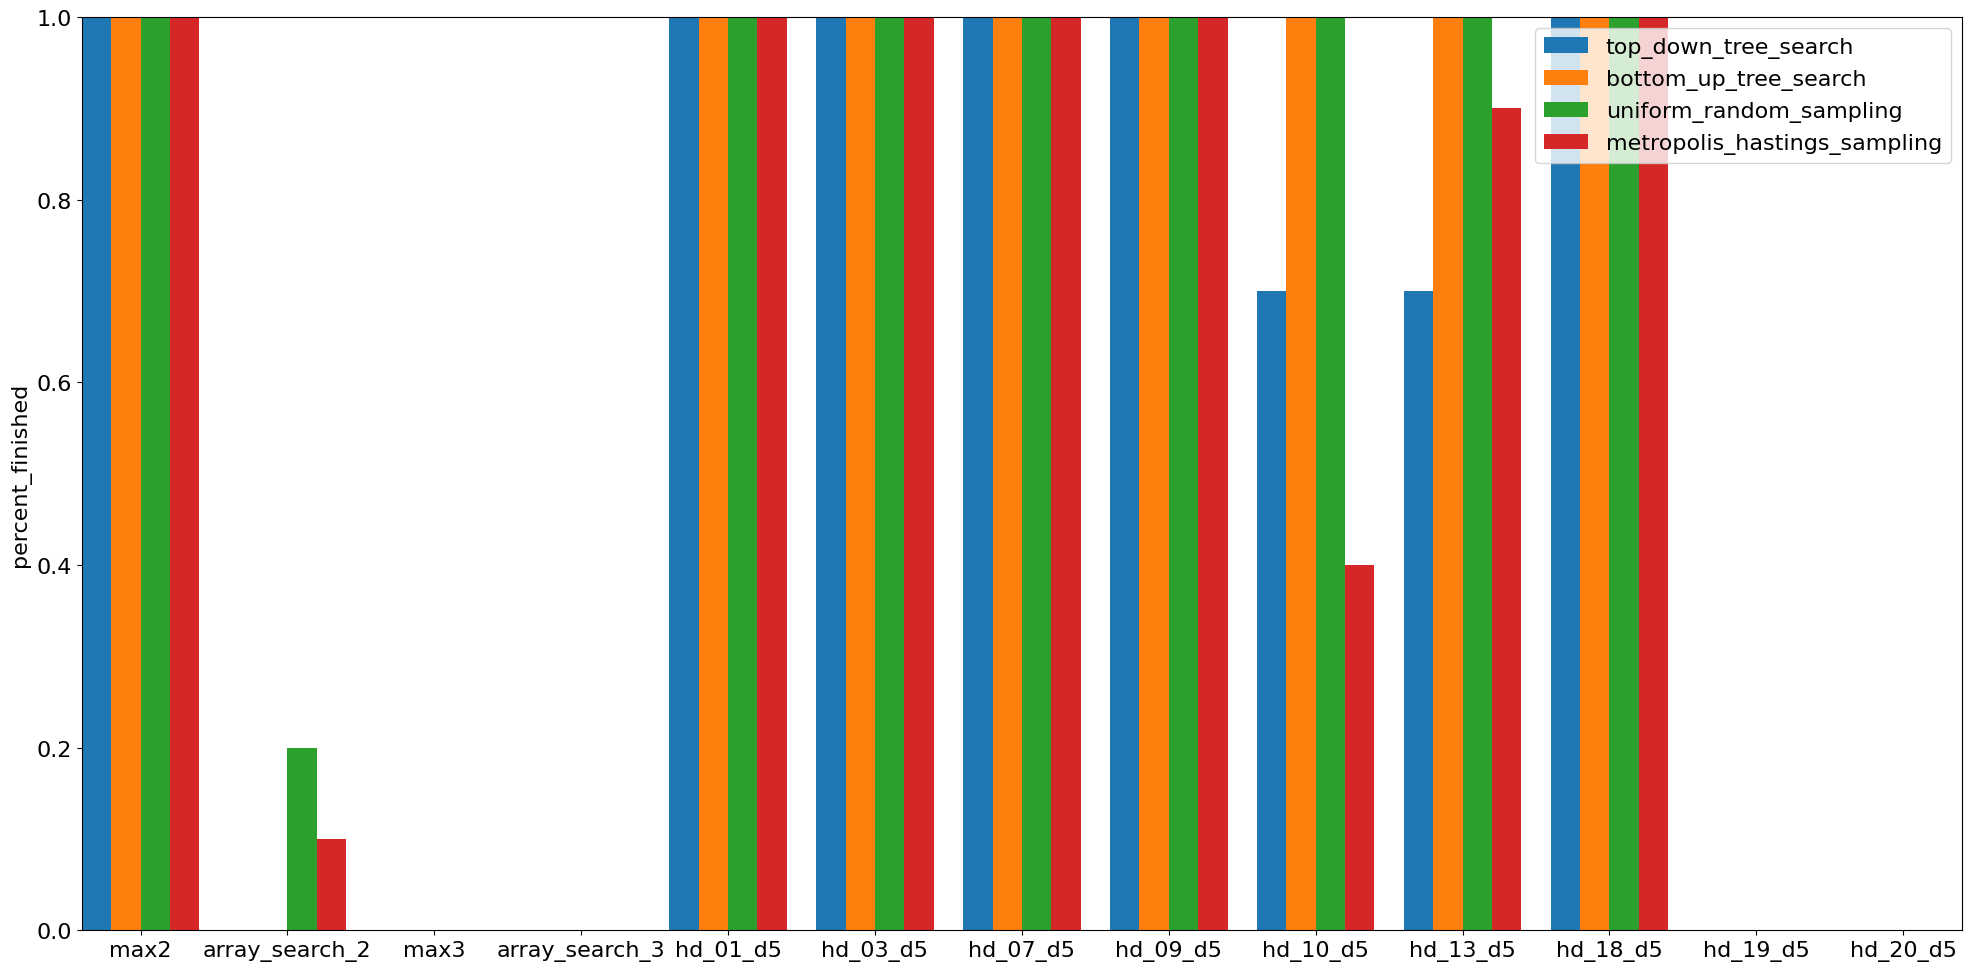

In [9]:
comparing_cfg_algorithms_percent_finished_figure, comparing_cfg_algorithms_percent_finished_axes = grouped_bar_chart_from_dataframe(
    comparing_cfg_algorithms_percent_finished_dataframe,
    data_column='percent_finished',
    group_bars_by='benchmark',
    label_bars_by='algorithm'
)


In [10]:
comparing_cfg_algorithms_percent_finished_figure.savefig('comparing_cfg_algorithms_percent_finished_figure.pdf')

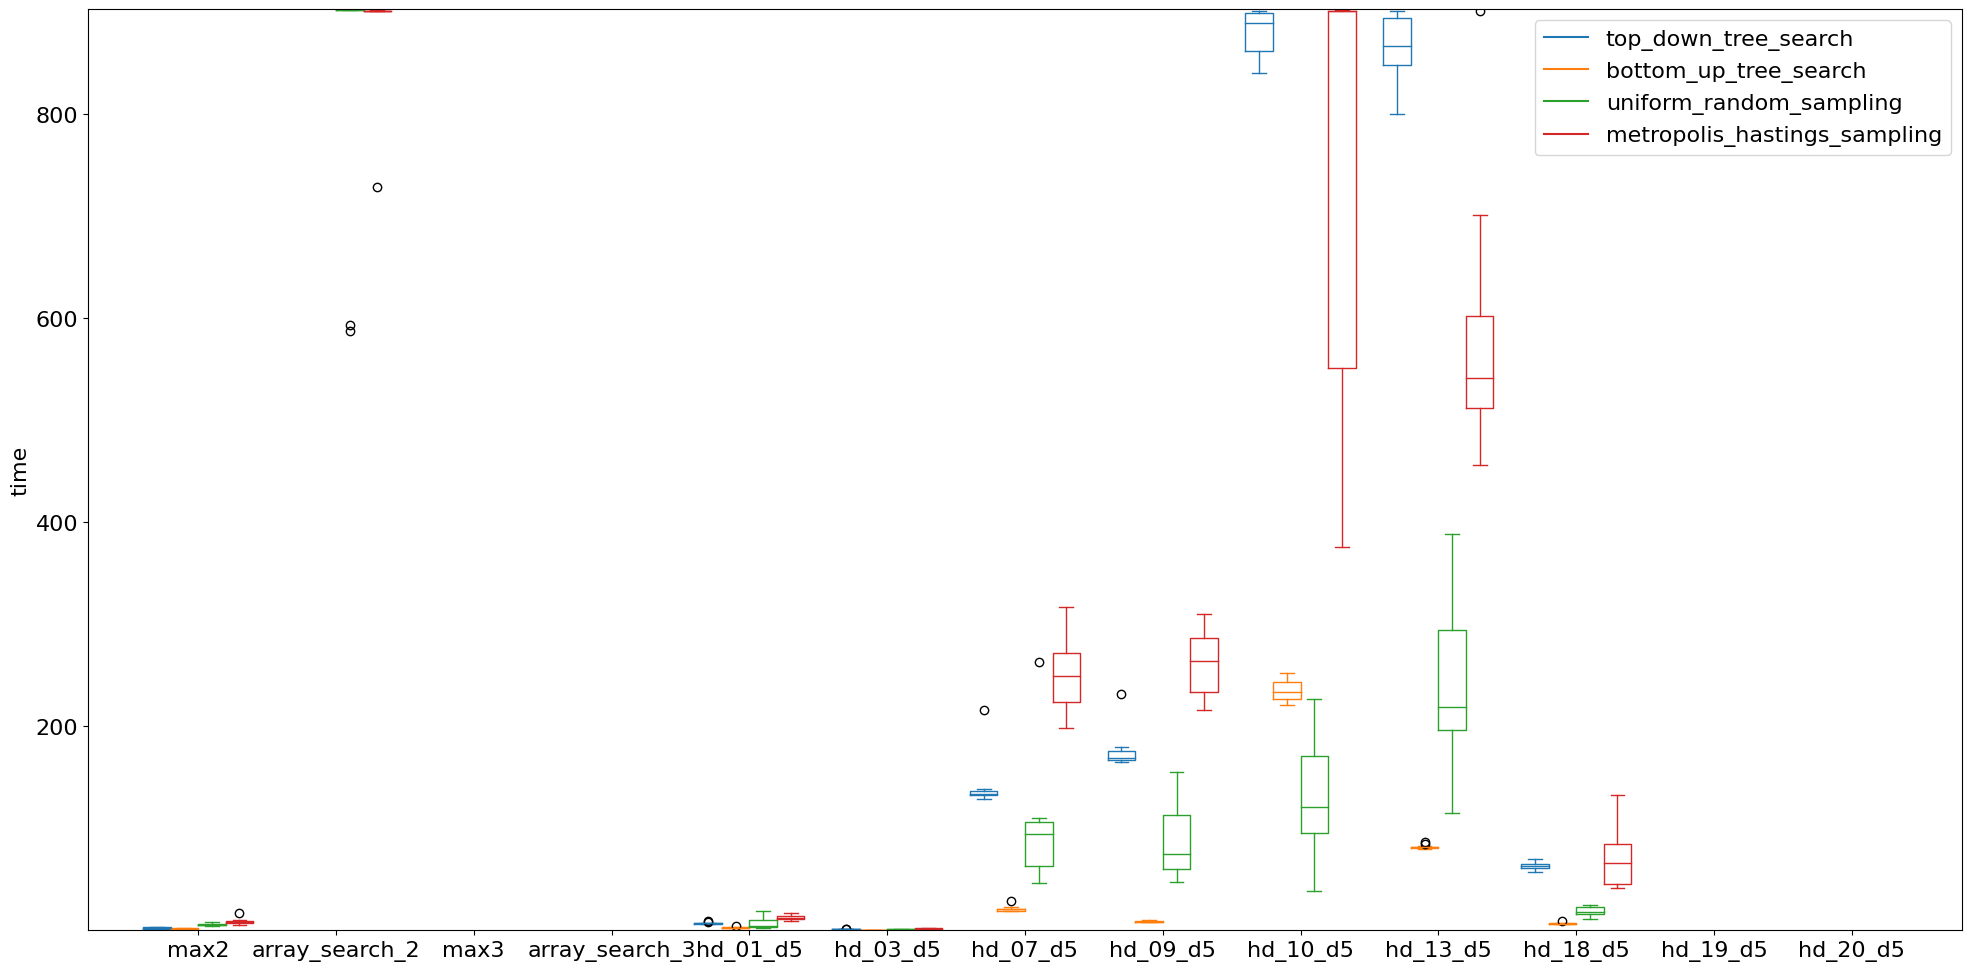

In [11]:
comparing_cfg_algorithms_time_figure, comparing_cfg_algorithms_time_axes = grouped_box_chart_from_dataframe(
    comparing_cfg_algorithms_time_dataframe,
    data_column='time',
    group_bars_by='benchmark',
    label_bars_by='algorithm',
)

In [12]:
comparing_cfg_algorithms_time_figure.savefig('comparing_cfg_algorithms_time_figure.pdf')

In [13]:
from collections import Counter
from multiprocessing import Pool
from shlex import split

from tqdm import tqdm


def parse_counterexample_from_log_line_components(
    # ['2023-04-26', '23:12:01,146', 'Received', 'counterexample', 'frozendict.frozendict({x: 4294443008})']
    # A log line MUST be split using shlex.split, NOT str.split
    components: list[str]
) -> str | None:
    if components[2:4] == ['Received', 'counterexample']:
        return components[4]
    else:
        return None


def parse_candidate_program_from_log_line_components(
    # ['2023-04-26','23:12:01,146','Found','candidate','program:','"4294967295"']
    # A log line MUST be split using shlex.split, NOT str.split
    components: list[str]
) -> str | None:
    if components[2:5] == ['Found', 'candidate', 'program:']:
        return components[5]
    else:
        return None


def parse_log_file(
    argument_tuple
):
    (benchmark, algorithm, log_file_path) = argument_tuple
    
    number_of_counterexamples = 0
    candidate_program_counter = Counter()

    with open(log_file_path, 'r') as fp:
        for line in fp:
            if 'Received counterexample' in line or 'Found candidate program:' in line:
                components = split(line)

                counterexample = parse_counterexample_from_log_line_components(components)
                if counterexample is not None:
                    number_of_counterexamples += 1

                candidate_program = parse_candidate_program_from_log_line_components(components)
                if candidate_program is not None:
                    candidate_program_counter[candidate_program] += 1
    return (
        benchmark,
        algorithm,
        number_of_counterexamples,
        sum(candidate_program_counter.values()),
        len(candidate_program_counter)
    )

        
def parse_number_of_counterexamples_number_of_candidate_programs_number_of_unique_candidate_programs_dataframe(
    # 'logs/'
    logs_directory: str
) -> pd.DataFrame:
    data = {
        'benchmark': [],
        'algorithm': [],
        'number_of_counterexamples': [],
        'number_of_candidate_programs': [],
        'number_of_unique_candidate_programs': []
    }

    argument_tuples = []
    # ['hd_18_d5']
    benchmarks = listdir(logs_directory)
    for benchmark in benchmarks:
        # 'logs/hd_18_d5'
        benchmark_directory = join(logs_directory, benchmark)
        # ['uniform_random_sampling']
        algorithms = listdir(benchmark_directory)
        for algorithm in algorithms:
            # 'logs/hd_18_d5/uniform_random_sampling'
            algorithms_directory = join(benchmark_directory, algorithm)
            # ['1']
            log_file_names = listdir(algorithms_directory)
            for log_file_name in log_file_names:
                log_file_path = join(algorithms_directory, log_file_name)
                
                argument_tuples.append((benchmark, algorithm, log_file_path))    
            
    with Pool(NUMBER_OF_PROCESSES) as pool:
        for (
            benchmark,
            algorithm,
            number_of_counterexamples,
            number_of_candidate_programs,
            number_of_unique_candidate_programs
        ) in pool.imap_unordered(
            parse_log_file,
            argument_tuples
        ):
            print('finished parsing log file for:', benchmark, algorithm)
            
            data['benchmark'].append(benchmark)
            data['algorithm'].append(algorithm)
            data['number_of_counterexamples'].append(number_of_counterexamples)
            data['number_of_candidate_programs'].append(number_of_candidate_programs)
            data['number_of_unique_candidate_programs'].append(number_of_unique_candidate_programs)
    
    return pd.DataFrame(data)

In [14]:
number_of_counterexamples_number_of_candidate_programs_number_of_unique_candidate_programs_dataframe = parse_number_of_counterexamples_number_of_candidate_programs_number_of_unique_candidate_programs_dataframe('logs/')
number_of_counterexamples_number_of_candidate_programs_number_of_unique_candidate_programs_dataframe

finished parsing log file for: array_search_2 eusolver
finished parsing log file for: array_search_2 eusolver
finished parsing log file for: array_search_2 eusolver
finished parsing log file for: array_search_2 eusolver
finished parsing log file for: array_search_2 eusolver
finished parsing log file for: array_search_2 top_down_tree_search
finished parsing log file for: array_search_2 top_down_tree_search
finished parsing log file for: array_search_2 top_down_tree_search
finished parsing log file for: array_search_2 top_down_tree_search
finished parsing log file for: array_search_2 top_down_tree_search
finished parsing log file for: array_search_2 top_down_tree_search
finished parsing log file for: array_search_2 top_down_tree_search
finished parsing log file for: array_search_2 top_down_tree_search
finished parsing log file for: array_search_2 top_down_tree_search
finished parsing log file for: array_search_2 top_down_tree_search
finished parsing log file for: array_search_2 metropoli

,benchmark,algorithm,number_of_counterexamples,number_of_candidate_programs,number_of_unique_candidate_programs
0,array_search_2,eusolver,8,12,12
1,array_search_2,eusolver,8,12,12
2,array_search_2,eusolver,8,12,12
3,array_search_2,eusolver,8,12,12
4,array_search_2,eusolver,8,12,12
...,...,...,...,...,...
535,hd_10_d5,bottom_up_tree_search,13,59542,59542
536,hd_10_d5,bottom_up_tree_search,13,59542,59542
537,hd_10_d5,metropolis_hastings_sampling,12,700646,13376
538,hd_10_d5,metropolis_hastings_sampling,11,916241,7809


In [15]:
import math



def get_average_number_of_counterexamples_average_number_of_candidate_programs_percentage_of_unique_candidate_programs_dataframe(algorithms: list[str], benchmarks: list[str]) -> pd.DataFrame:
    summary_data = {
        'algorithm': [],
        'benchmark': [],
        'average_number_of_counterexamples': [],
        'average_number_of_candidate_programs': [],
        'percentage_of_unique_candidate_programs': [],
    }

    for algorithm in algorithms:
        for benchmark in benchmarks:
            subdataframe = number_of_counterexamples_number_of_candidate_programs_number_of_unique_candidate_programs_dataframe[
                (number_of_counterexamples_number_of_candidate_programs_number_of_unique_candidate_programs_dataframe['algorithm'] == algorithm) & (number_of_counterexamples_number_of_candidate_programs_number_of_unique_candidate_programs_dataframe['benchmark'] == benchmark)
            ]
            
            average_number_of_counterexamples = subdataframe['number_of_counterexamples'].mean()
            average_number_of_candidate_programs = subdataframe['number_of_candidate_programs'].mean()
            average_number_of_unique_candidate_programs = subdataframe['number_of_unique_candidate_programs'].mean()
            
            summary_data['algorithm'].append(algorithm)
            summary_data['benchmark'].append(benchmark)
            summary_data['average_number_of_counterexamples'].append(average_number_of_counterexamples)
            summary_data['average_number_of_candidate_programs'].append(average_number_of_candidate_programs)
            summary_data['percentage_of_unique_candidate_programs'].append(average_number_of_unique_candidate_programs / average_number_of_candidate_programs * 100)

    return pd.DataFrame(summary_data)

In [17]:
average_number_of_counterexamples_average_number_of_candidate_programs_percentage_of_unique_candidate_programs_dataframe = get_average_number_of_counterexamples_average_number_of_candidate_programs_percentage_of_unique_candidate_programs_dataframe(
    [
        'top_down_tree_search',
        'bottom_up_tree_search',
        'uniform_random_sampling',
        'metropolis_hastings_sampling'
    ],
    [
        'max2',
        'array_search_2',
        'max3',
        'array_search_3',
        'hd_01_d5',
        'hd_03_d5',
        'hd_07_d5',
        'hd_09_d5',
        'hd_10_d5',
        'hd_13_d5',
        'hd_18_d5',
        'hd_19_d5',
        'hd_20_d5'
    ]
)
average_number_of_counterexamples_average_number_of_candidate_programs_percentage_of_unique_candidate_programs_dataframe

,algorithm,benchmark,average_number_of_counterexamples,average_number_of_candidate_programs,percentage_of_unique_candidate_programs
0,top_down_tree_search,max2,6.0,97.0,100.000000
1,top_down_tree_search,array_search_2,6.0,1446.0,100.000000
2,top_down_tree_search,max3,7.0,38169.6,100.000000
3,top_down_tree_search,array_search_3,4.0,4936.0,100.000000
4,top_down_tree_search,hd_01_d5,2.0,557.0,100.000000
5,top_down_tree_search,hd_03_d5,2.0,177.0,100.000000
6,top_down_tree_search,hd_07_d5,3.0,4965.0,100.000000
7,top_down_tree_search,hd_09_d5,3.0,7560.0,100.000000
8,top_down_tree_search,hd_10_d5,14.0,53881.2,100.000000
9,top_down_tree_search,hd_13_d5,7.0,35823.6,99.994417


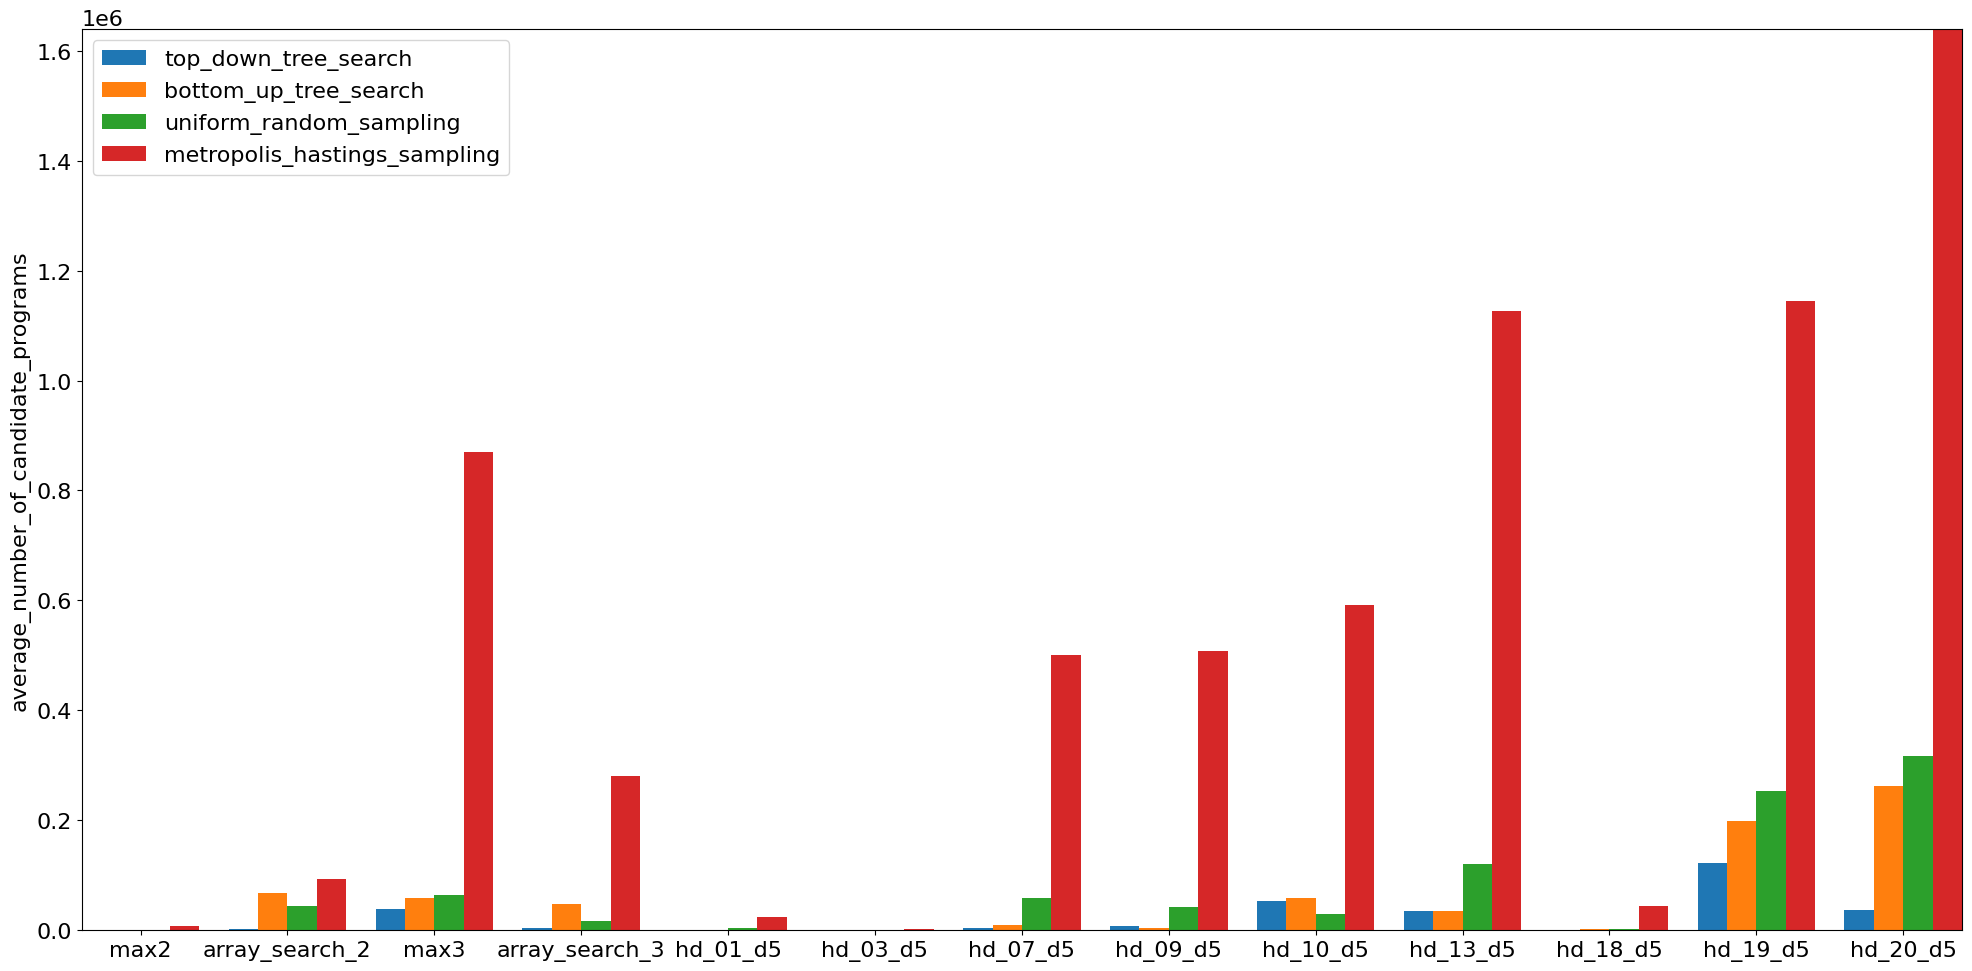

In [18]:
comparing_cfg_algorithms_average_number_of_candidate_programs_figure, comparing_cfg_algorithms_average_number_of_candidate_programs_axes = grouped_bar_chart_from_dataframe(
    average_number_of_counterexamples_average_number_of_candidate_programs_percentage_of_unique_candidate_programs_dataframe,
    data_column='average_number_of_candidate_programs',
    group_bars_by='benchmark',
    label_bars_by='algorithm'
)

In [19]:
comparing_cfg_algorithms_average_number_of_candidate_programs_figure.savefig('comparing_cfg_algorithms_average_number_of_candidate_programs_figure.pdf')

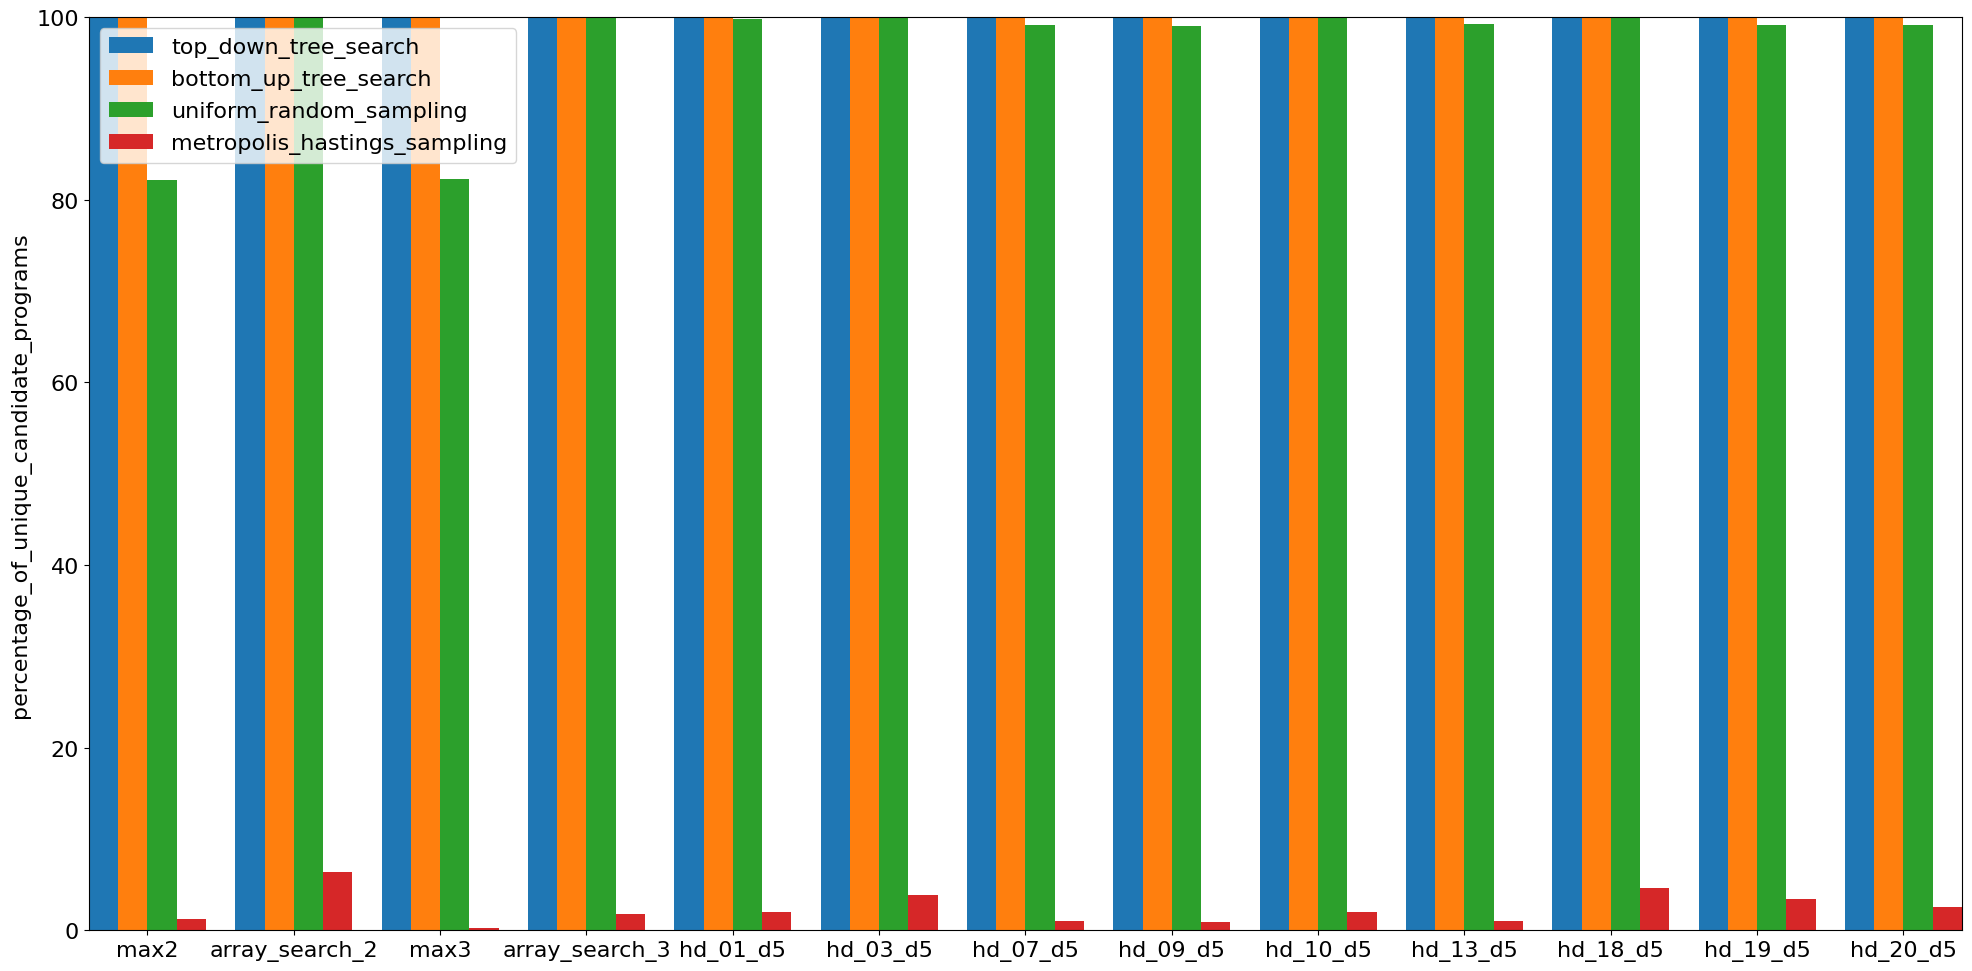

In [21]:
comparing_cfg_algorithms_percentage_of_unique_candidate_programs_figure, comparing_cfg_algorithms_percentage_of_unique_candidate_programs_axes = grouped_bar_chart_from_dataframe(
    average_number_of_counterexamples_average_number_of_candidate_programs_percentage_of_unique_candidate_programs_dataframe,
    data_column='percentage_of_unique_candidate_programs',
    group_bars_by='benchmark',
    label_bars_by='algorithm'
)

In [23]:
comparing_cfg_algorithms_percentage_of_unique_candidate_programs_figure.savefig('comparing_cfg_algorithms_percentage_of_unique_candidate_programs_figure.pdf')

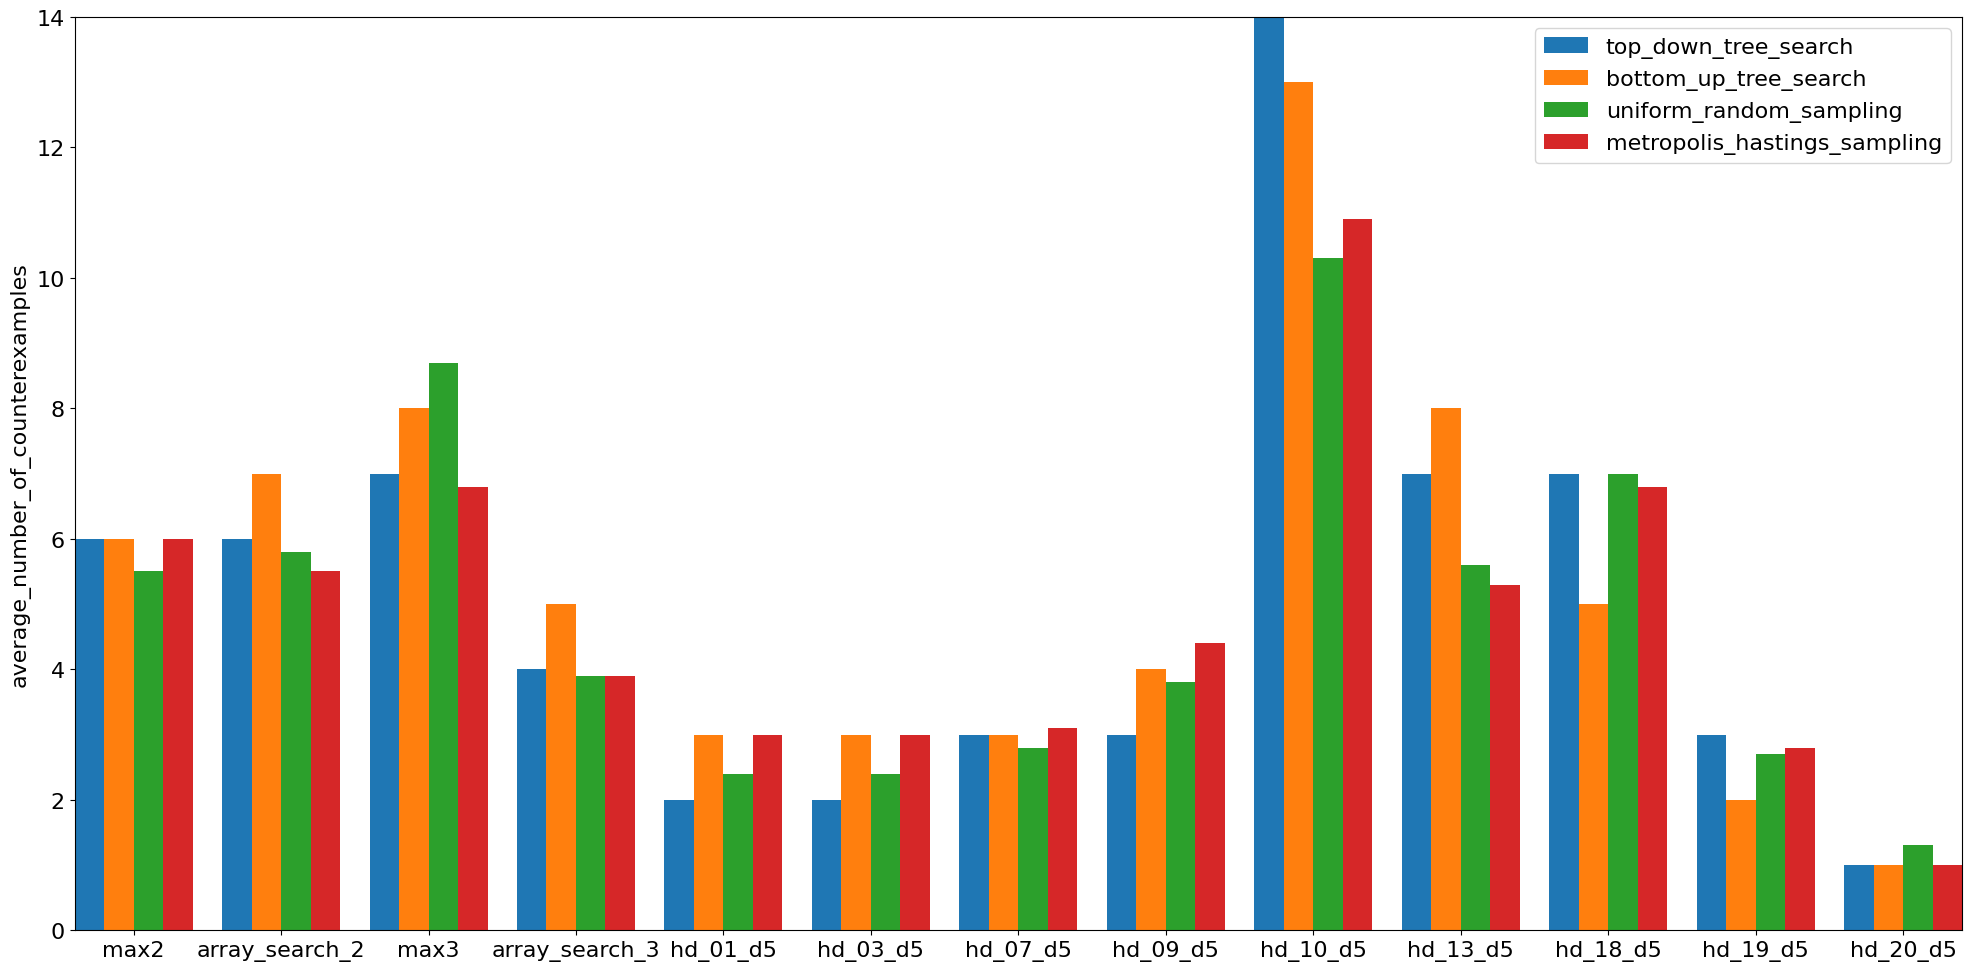

In [24]:
comparing_cfg_algorithms_average_number_of_counterexamples_figure, comparing_cfg_algorithms_average_number_of_counterexamples_axes = grouped_bar_chart_from_dataframe(
    average_number_of_counterexamples_average_number_of_candidate_programs_percentage_of_unique_candidate_programs_dataframe,
    data_column='average_number_of_counterexamples',
    group_bars_by='benchmark',
    label_bars_by='algorithm'
)

In [25]:
comparing_cfg_algorithms_average_number_of_counterexamples_figure.savefig('comparing_cfg_algorithms_average_number_of_counterexamples_figure.pdf')

In [26]:
comparing_all_algorithms_time_dataframe = get_time_dataframe(
    [
        'top_down_tree_search',
        'bottom_up_tree_search',
        'uniform_random_sampling',
        'metropolis_hastings_sampling',
        'eusolver'
    ],
    [
        'max2',
        'array_search_2',
        'max3',
        'array_search_3'
    ]
)
comparing_all_algorithms_time_dataframe

,algorithm,benchmark,time
0,top_down_tree_search,max2,1.791
1,top_down_tree_search,max2,2.975
2,top_down_tree_search,max2,2.999
3,top_down_tree_search,max2,3.027
4,top_down_tree_search,max2,2.982
...,...,...,...
85,eusolver,array_search_3,2.396
86,eusolver,array_search_3,2.269
87,eusolver,array_search_3,2.246
88,eusolver,array_search_3,2.327


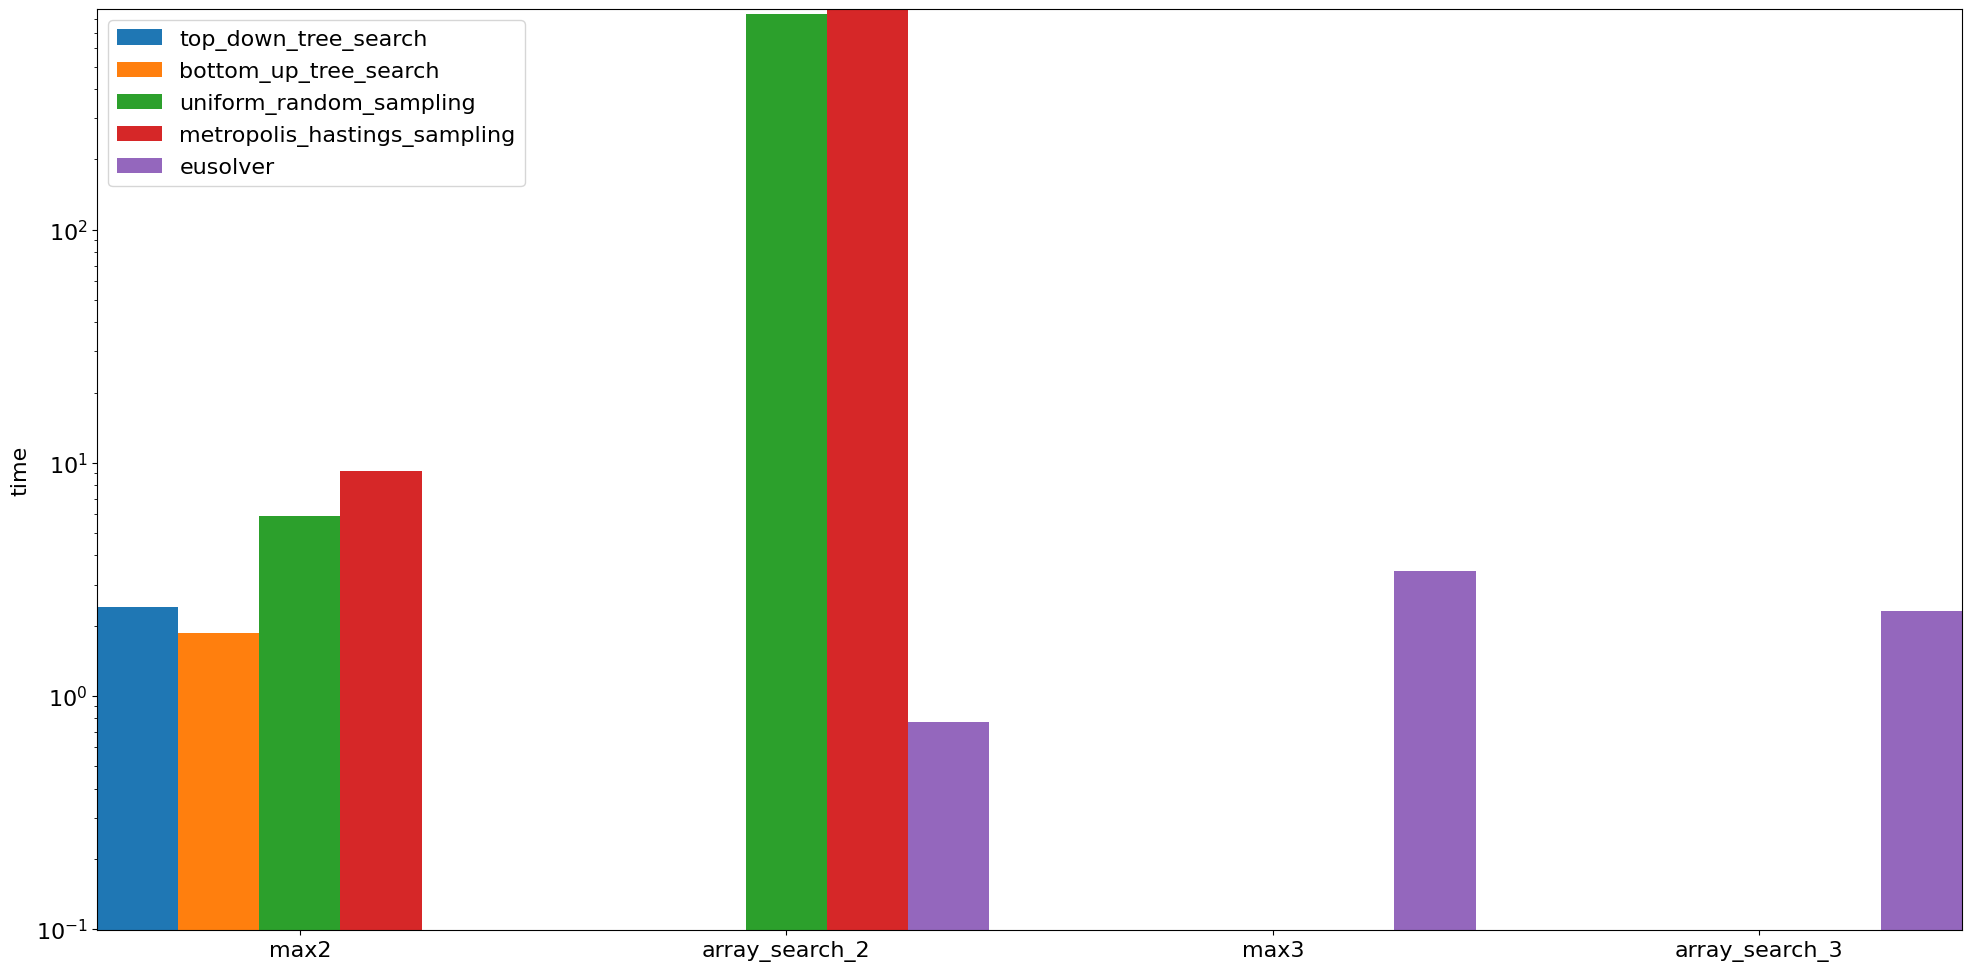

In [27]:
comparing_all_algorithms_time_figure, comparing_all_algorithms_time_axes = grouped_average_bar_chart_from_dataframe(
    comparing_all_algorithms_time_dataframe,
    data_column='time',
    group_bars_by='benchmark',
    label_bars_by='algorithm',
    log=True
)

In [28]:
comparing_all_algorithms_time_figure.savefig('comparing_all_algorithms_time_figure.pdf')

In [29]:
import math



def get_average_number_of_unique_candidate_programs_dataframe(algorithms: list[str], benchmarks: list[str]) -> pd.DataFrame:
    summary_data = {
        'algorithm': [],
        'benchmark': [],
        'average_number_of_unique_candidate_programs': [],
    }

    for algorithm in algorithms:
        for benchmark in benchmarks:
            subdataframe = number_of_counterexamples_number_of_candidate_programs_number_of_unique_candidate_programs_dataframe[
                (number_of_counterexamples_number_of_candidate_programs_number_of_unique_candidate_programs_dataframe['algorithm'] == algorithm) & (number_of_counterexamples_number_of_candidate_programs_number_of_unique_candidate_programs_dataframe['benchmark'] == benchmark)
            ]
            
            average_number_of_unique_candidate_programs = subdataframe['number_of_unique_candidate_programs'].mean()
            
            summary_data['algorithm'].append(algorithm)
            summary_data['benchmark'].append(benchmark)
            summary_data['average_number_of_unique_candidate_programs'].append(average_number_of_unique_candidate_programs)

    return pd.DataFrame(summary_data)

In [30]:
comparing_all_algorithms_average_number_of_unique_candidate_programs_dataframe = get_average_number_of_unique_candidate_programs_dataframe(
    [
        'top_down_tree_search',
        'bottom_up_tree_search',
        'uniform_random_sampling',
        'metropolis_hastings_sampling',
        'eusolver'
    ],
    [
        'max2',
        'array_search_2',
        'max3',
        'array_search_3'
    ]
)
comparing_all_algorithms_average_number_of_unique_candidate_programs_dataframe

,algorithm,benchmark,average_number_of_unique_candidate_programs
0,top_down_tree_search,max2,97.0
1,top_down_tree_search,array_search_2,1446.0
2,top_down_tree_search,max3,38169.6
3,top_down_tree_search,array_search_3,4936.0
4,bottom_up_tree_search,max2,158.0
5,bottom_up_tree_search,array_search_2,66951.2
6,bottom_up_tree_search,max3,58290.3
7,bottom_up_tree_search,array_search_3,48016.2
8,uniform_random_sampling,max2,588.2
9,uniform_random_sampling,array_search_2,44229.4


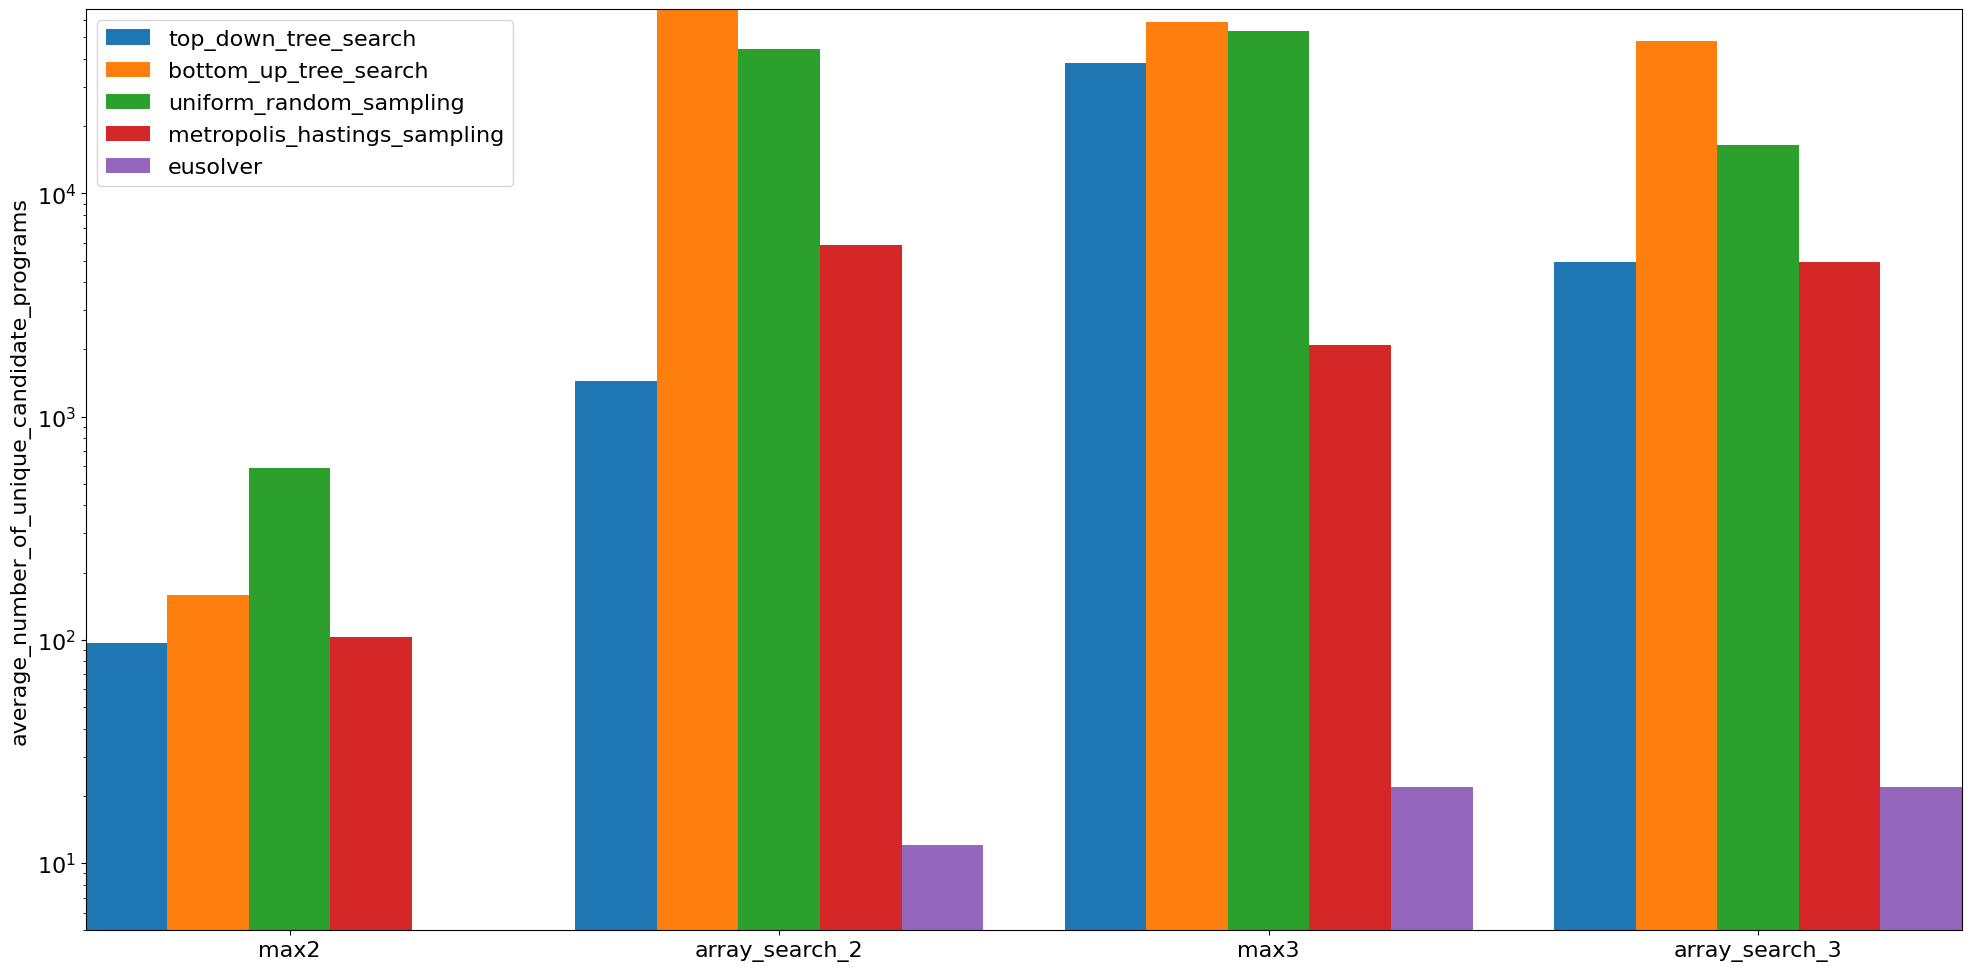

In [33]:
comparing_all_algorithms_average_number_of_unique_candidate_programs_figure, comparing_all_algorithms_average_number_of_unique_candidate_programs_axes = grouped_bar_chart_from_dataframe(
    comparing_all_algorithms_average_number_of_unique_candidate_programs_dataframe,
    data_column='average_number_of_unique_candidate_programs',
    group_bars_by='benchmark',
    label_bars_by='algorithm',
    log=True
)

In [34]:
comparing_all_algorithms_average_number_of_unique_candidate_programs_figure.savefig('comparing_all_algorithms_average_number_of_unique_candidate_programs_figure.pdf')